In [231]:
import math
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [232]:
def rot_img(feature_map, i = 1):
    return torch.rot90(feature_map, k = i)
def rot_rototranslation_map(feature_map, i = 1):
    return torch.roll(torch.rot90(feature_map, k = i, dims = [1, 2]), shifts = i, dims = 0)

In [241]:
class Gconv_lifting(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels  
        self.k = kernel_size 
        self.kernels = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size)) 
        self.bias = nn.Parameter(torch.randn(out_channels))
    
    def forward(self, feature_map):
        batch_size, _, ih, iw = feature_map.shape
        output_h = ih - self.k + 1
        output_w = iw - self.k + 1
        device = feature_map.device

        rotated_kernels = torch.zeros(self.out_channels * 4, self.in_channels, self.k, self.k, device = device)
        for out in range(self.out_channels):
            for inp in range(self.in_channels):
                rotated_kernels[out * 4][inp] = self.kernels[out][inp]
                for rot in range(1, 4):
                    rotated_kernels[out * 4 + rot][inp] = rot_img(self.kernels[out][inp], i = rot)

        expanded_bias = torch.repeat_interleave(self.bias, repeats = 4)
        conv = torch.conv2d(feature_map, rotated_kernels, bias = expanded_bias)
        return conv.reshape(batch_size, self.out_channels, 4, output_h, output_w)

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(8, 4))

for group in range(2):
    for i in range(4):
        axes[group, i].imshow(out[0][group, i], cmap='gray')
        axes[group, i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
rot_t = torch.zeros(*t.shape)
for i in range(2):
    rot_t[i][0] = rot_img(t[i][0])
    rot_t[i][1] = rot_img(t[i][1])
rot_out = gconvl(rot_t).detach()

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(8, 4))

for group in range(2):
    for i in range(4):
        axes[group, i].imshow(rot_out[0][group, i], cmap='gray')
        axes[group, i].axis('off')

plt.tight_layout()
plt.show()

In [242]:
class Gconv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels  
        self.k = kernel_size 
        self.kernels = nn.Parameter(torch.randn(out_channels, in_channels, 4, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.randn(out_channels))
    
    def forward(self, feature_map): 
        batch_size, _, _, ih, iw = feature_map.shape
        output_h = ih - self.k + 1
        output_w = iw - self.k + 1
        device = feature_map.device

        rotated_kernels = torch.zeros(self.out_channels * 4, self.in_channels, 4, self.k, self.k, device = device)
        for out in range(self.out_channels):
            for inp in range(self.in_channels):
                rotated_kernels[out * 4][inp] = self.kernels[out][inp]
                for rot in range(1, 4):
                    rotated_kernels[out * 4 + rot][inp] = rot_rototranslation_map(self.kernels[out][inp], i = rot)
        rotated_kernels = rotated_kernels.reshape(self.out_channels * 4, self.in_channels * 4, self.k, self.k)

        expanded_bias = torch.repeat_interleave(self.bias, repeats = 4)
        
        stacked_feature_map = feature_map.reshape(batch_size, self.in_channels * 4, ih, iw)
        conv = torch.conv2d(stacked_feature_map, rotated_kernels, bias = expanded_bias)
        return conv.reshape(batch_size, self.out_channels, 4, output_h, output_w)

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(8, 4))

for group in range(2):
    for i in range(4):
        axes[group, i].imshow(out[1][group, i], cmap='gray')
        axes[group, i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
rot_t = torch.zeros(*t.shape)
for i in range(2):    
    rot_t[i][0] = rot_rototranslation_map(t[i][0])
    rot_t[i][1] = rot_rototranslation_map(t[i][1])
rot_out = gconv(rot_t).detach()

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(8, 4))

for group in range(2):
    for i in range(4):
        axes[group, i].imshow(rot_out[1][group, i], cmap='gray')
        axes[group, i].axis('off')

plt.tight_layout()
plt.show()

In [243]:
def max_projection(feature_map):
    return feature_map.max(dim = 2).values

In [244]:
class GCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.gconv1 = Gconv_lifting(1, 8, 3)
        self.gconv2 = Gconv(8, 16, 3)
        # self.gconv3 = nGconv(16, 32, 3)
        # self.gconv4 = nGconv(32, 64, 3)
        # self.gconv5 = nGconv(64, 128, 3)
        self.pool3d1 = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        self.pool3d2 = nn.MaxPool3d(kernel_size=(4, 3, 3), stride=(1, 1, 1), padding=(0, 0, 0))
        self.fc1 = nn.Linear(1296, 10)
        # self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.relu(self.pool3d1(self.gconv1(x)))
        x = F.relu(self.pool3d2(self.gconv2(x)))
        # x = F.relu(self.pool3d1(self.gconv3(x)))
        # x = F.relu(self.pool3d1(self.gconv4(x)))
        # x = F.relu(self.pool3d2(self.gconv5(x)))
        # x = max_projection(x)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.fc1(x)
        return x

gcnn = GCNN()

In [245]:
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        magic = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        num_rows = int.from_bytes(f.read(4), 'big')
        num_cols = int.from_bytes(f.read(4), 'big')

        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images.reshape((num_images, num_rows, num_cols))
        return images

train_images = load_mnist_images('/kaggle/input/mnist-dataset/train-images.idx3-ubyte') 

In [246]:
import os
import struct
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Path to Kaggle input directory
data_path = "/kaggle/input/mnist-dataset"  # replace with actual folder if needed

# --- Binary reader functions ---
def read_images(filename):
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images.reshape(num, 1, rows, cols)
        return images

def read_labels(filename):
    with open(filename, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

# --- Read raw data ---
train_images = read_images(os.path.join(data_path, "train-images.idx3-ubyte"))
train_labels = read_labels(os.path.join(data_path, "train-labels.idx1-ubyte"))

test_images = read_images(os.path.join(data_path, "t10k-images.idx3-ubyte"))
test_labels = read_labels(os.path.join(data_path, "t10k-labels.idx1-ubyte"))

# --- Custom PyTorch Dataset ---
class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = torch.tensor(images, dtype=torch.float32) / 255.0
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# --- Transforms and DataLoaders ---
transform = transforms.Compose([
    transforms.Normalize((0.1307,), (0.3081,))
])

train_images_subset = train_images[:]
train_labels_subset = train_labels[:]

train_dataset = MNISTDataset(train_images_subset, train_labels_subset, transform=transform)
test_dataset = MNISTDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size = 100, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 100)

In [247]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = gcnn.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)
num_epochs = 5  # you can increase this later

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:  # print every 100 mini-batches
            print(f"[Epoch {epoch+1}, Batch {i+1}] loss: {running_loss / 100:.4f}")
            running_loss = 0.0

print("Finished Training ✅")

[Epoch 1, Batch 100] loss: 21.0285
[Epoch 1, Batch 200] loss: 7.7512
[Epoch 1, Batch 300] loss: 5.0848
[Epoch 1, Batch 400] loss: 3.7591
[Epoch 1, Batch 500] loss: 3.2552
[Epoch 1, Batch 600] loss: 2.6957
[Epoch 2, Batch 100] loss: 2.2941
[Epoch 2, Batch 200] loss: 2.1443
[Epoch 2, Batch 300] loss: 1.9616
[Epoch 2, Batch 400] loss: 1.7911
[Epoch 2, Batch 500] loss: 1.6133
[Epoch 2, Batch 600] loss: 1.5663
[Epoch 3, Batch 100] loss: 1.4433
[Epoch 3, Batch 200] loss: 1.3778
[Epoch 3, Batch 300] loss: 1.3050
[Epoch 3, Batch 400] loss: 1.2475
[Epoch 3, Batch 500] loss: 1.1437
[Epoch 3, Batch 600] loss: 1.1367
[Epoch 4, Batch 100] loss: 1.0331
[Epoch 4, Batch 200] loss: 0.9874
[Epoch 4, Batch 300] loss: 1.0491
[Epoch 4, Batch 400] loss: 0.9654
[Epoch 4, Batch 500] loss: 0.9493
[Epoch 4, Batch 600] loss: 0.8891
[Epoch 5, Batch 100] loss: 0.8747
[Epoch 5, Batch 200] loss: 0.8438
[Epoch 5, Batch 300] loss: 0.8671
[Epoch 5, Batch 400] loss: 0.8369
[Epoch 5, Batch 500] loss: 0.7111
[Epoch 5, Bat

In [248]:
model.eval()

correct = 0
total = 10000

# Prepare the first 20 images and labels
images = test_images[:total]
labels = test_labels[:total]
# print(labels)

# Normalize and convert to tensor
images_tensor = torch.tensor(images, dtype=torch.float32) / 255.0
images_tensor = torch.stack([transforms.Normalize((0.1307,), (0.3081,))(img) for img in images_tensor])
images_tensor = images_tensor.to(device)
labels_tensor = torch.tensor(labels, dtype=torch.long).to(device)

# Get predictions
with torch.no_grad():
    outputs = model(images_tensor)
    preds = torch.argmax(outputs, dim=1)

# Calculate accuracy
correct = (preds == labels_tensor).sum().item()
accuracy = correct / total * 100

print(f"Accuracy on first 20 images: {accuracy:.2f}%")

Accuracy on first 20 images: 90.07%


In [249]:
torch.save(model.state_dict(), "gcnn_weights.pth")

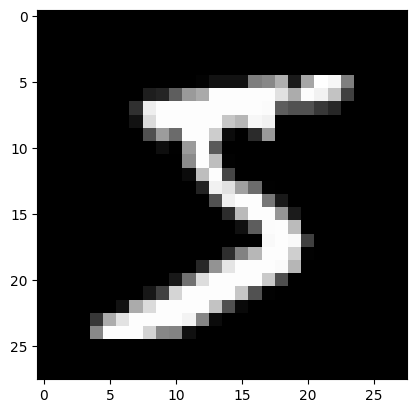

In [61]:
plt.imshow(images[0].reshape(28, 28), cmap = 'gray')

In [83]:
gc = Gconv_lifting(1, 2, 3)

In [84]:
imaget = torch.Tensor(images[0])
out = gc(imaget.reshape(1, 1, 28, 28)).detach()

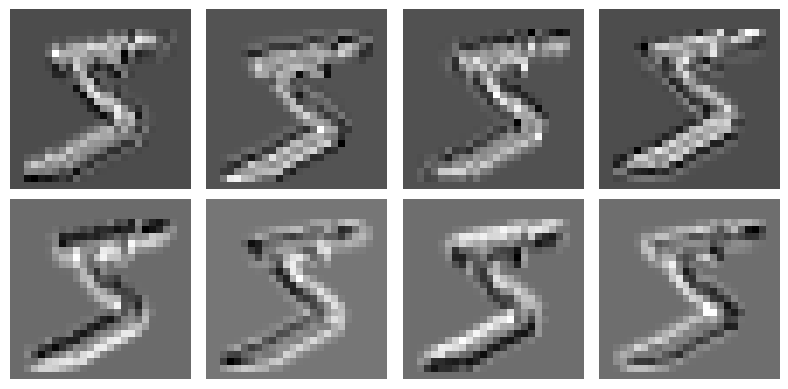

In [85]:
fig, axes = plt.subplots(2, 4, figsize=(8, 4))

for group in range(2):
    for i in range(4):
        axes[group, i].imshow(out.detach()[0][group, i], cmap='gray')
        axes[group, i].axis('off')

plt.tight_layout()
plt.show()

In [86]:
rot_t = torch.zeros(*imaget.shape)
rot_t[0] = rot_img(imaget[0])
rot_out = gc(rot_t.reshape(1, 1, 28, 28)).detach()

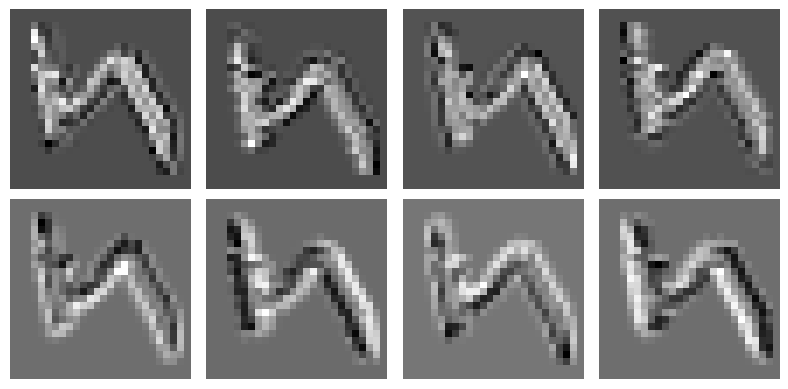

In [87]:
fig, axes = plt.subplots(2, 4, figsize=(8, 4))

for group in range(2):
    for i in range(4):
        axes[group, i].imshow(rot_out[0][group, i], cmap='gray')
        axes[group, i].axis('off')

plt.tight_layout()
plt.show()